<a href="https://colab.research.google.com/github/Joselyne50/DEEPLEARNING/blob/main/Fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, \
                               Flatten, Dense, GlobalAveragePooling2D, \
                                  Dropout, BatchNormalization, ReLU

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, \
                    classification_report

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [5]:
#  Current working directory according to project
os.chdir('/content/drive/MyDrive/Semester2/Advanced_cv')

# Utilities

In our project we seperating cnn block from six softmax blocks. Thereby we need a feature extractor, which utilizes the base model such as pretrained Resnet or else. It starts a loop, taking all image paths into account, one by one it loads an image, passes it Base models CNN layer extract features, flatten them and returns the flatten features.

In [6]:
def feature_extractor(data, image_size, base_model):

    input_shape = (image_size, image_size, 3)
    inputs = Input(shape=input_shape,name = 'image_input')
    x = base_model(inputs)
    x = Flatten()(x)
    model = Model(inputs=inputs, outputs=x)

    features_retrieved = []

    for img_path in tqdm(data, total=len(data), desc="Retrieving features"):
        img = load_img(img_path, target_size=(image_size, image_size))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        features = model.predict(x, verbose=0)
        features_reduce =  features.squeeze()

        features_retrieved.append(features_reduce)

    return features_retrieved

# Hyperparameters

In [7]:
IMAGE_SIZE=150
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE=32
NUM_SUBCATEGORIES = [7, 3, 3, 4, 6, 3]
BASE_MODEL = ResNet101(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

171446536/171446536 [==============================] - 1s 0us/step


# Data

## Data Reading

In [8]:
attributes = pd.read_csv('data/raw/split/list_attr_cloth.txt', delim_whitespace=True, skiprows=1)

In [9]:
attribute_mapping  = {i: attr for i, attr in enumerate(attributes.attribute_name, start=0)}

In [10]:
# Define paths
image_dir = 'data/raw'
train_image_path = 'data/raw/split/train.txt'
train_attr_path = 'data/raw/split/train_attr.txt'
val_image_path = 'data/raw/split/val.txt'
val_attr_path = 'data/raw/split/val_attr.txt'
test_image_path = 'data/raw/split/test.txt'

# Load the training image paths
with open(train_image_path, 'r') as f:
    train_image_paths = [line.strip() for line in f.readlines()]

# Load the training labels
with open(train_attr_path, 'r') as f:
    train_labels = [list(map(int, line.strip().split())) for line in f.readlines()]

# Load the validation image paths
with open(val_image_path, 'r') as f:
    val_image_paths = [line.strip() for line in f.readlines()]

# Load the validation labels
with open(val_attr_path, 'r') as f:
    val_labels = [list(map(int, line.strip().split())) for line in f.readlines()]

# Load the testing image paths
with open(test_image_path, 'r') as f:
    test_image_paths = [line.strip() for line in f.readlines()]

In [11]:
# Saving the labels

np.save('data/processed/train/train_labels.npy', train_labels)
np.save('data/processed/val/val_labels.npy', val_labels)

In [12]:
# Arranging the paths

train_image_paths = [os.path.join(image_dir, image_path) for image_path in train_image_paths]
val_image_paths = [os.path.join(image_dir, image_path) for image_path in val_image_paths]
test_image_paths = [os.path.join(image_dir, image_path) for image_path in test_image_paths]

## Feature Extraction

In [ ]:
# Extracting training data features and saving it at data/processed/train

train_data_features = feature_extractor(
    data=train_image_paths,
    image_size=IMAGE_SIZE,
    base_model=BASE_MODEL)

train_data_features = np.array(train_data_features)

print("Train data features features", train_data_features.shape)
np.save('data/processed/train/train_data_features.npy', train_data_features)
print('Training data features saved at data/processed/train/train_data_features.npy')

In [13]:
# Extracting validation data features and saving it at data/processed/val

val_data_features = feature_extractor(
    data=val_image_paths,
    image_size=IMAGE_SIZE,
    base_model=BASE_MODEL)

val_data_features = np.array(val_data_features)

print("Train data features features", val_data_features.shape)
np.save('data/processed/val/val_data_features.npy', val_data_features)
print('Training data features saved at data/processed/val/val_data_features.npy')

Retrieving features:   0%|          | 0/1000 [00:00<?, ?it/s]

Train data features features (1000, 51200)
Training data features saved at data/processed/val/val_data_features.npy


In [14]:
# Extracting testing data features and saving it at data/processed/val

test_data_features = feature_extractor(
    data=test_image_paths,
    image_size=IMAGE_SIZE,
    base_model=BASE_MODEL)

test_data_features = np.array(test_data_features)

print("Train data features features", test_data_features.shape)
np.save('data/processed/test/test_data_features.npy', test_data_features)
print('Training data features saved at data/processed/test/test_data_features.npy')

Retrieving features:   0%|          | 0/1000 [00:00<?, ?it/s]

Train data features features (1000, 51200)
Training data features saved at data/processed/test/test_data_features.npy


# Output 0

## Loading Features and Labels

In [15]:
train_data_features = np.load('data/processed/train/train_data_features.npy')
train_data_labels = np.load('data/processed/train/train_labels.npy')

val_data_features = np.load('data/processed/val/val_data_features.npy')
val_data_labels = np.load('data/processed/val/val_labels.npy')

In [16]:
N = 0 # Choosing which label to work with

train_data_labels_n = train_data_labels[:, N]
print("Training distribution:", Counter(train_data_labels_n))

val_data_labels_n = val_data_labels[:, N]
print("Validation distribution:", Counter(val_data_labels_n))

Training distribution: Counter({5: 2408, 1: 853, 0: 768, 3: 422, 2: 334, 4: 109, 6: 106})
Validation distribution: Counter({5: 458, 0: 192, 1: 175, 3: 77, 2: 65, 6: 20, 4: 13})


## Balancing training dataset

In [17]:
# Set the target number of samples for each class
target_samples = 1000

# Upsampling Minority classes using SMOTE
smote = SMOTE(sampling_strategy={
    0: 1000,
    1: 2000,
    2: 1000,
    3: 1000,
    4: 1000,
    6: 1000
})

oversampled_features, oversampled_labels = smote.fit_resample(train_data_features, train_data_labels_n)

# Downsample the majority class using RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy={
    5: 2400
})

undersampled_features, undersampled_labels = undersampler.fit_resample(oversampled_features, oversampled_labels)

print("Class distribution after balancing:", Counter(undersampled_labels))
print("Shape of oversampled features:", undersampled_labels.shape)
print("Shape of oversampled labels:", undersampled_labels.shape)

Class distribution after balancing: Counter({5: 2400, 1: 2000, 0: 1000, 2: 1000, 3: 1000, 4: 1000, 6: 1000})
Shape of oversampled features: (9400,)
Shape of oversampled labels: (9400,)


## Training

In [42]:
input = Input(shape=(val_data_features.shape[1],))
x = Dense(512)(input)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = ReLU()(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = ReLU()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = ReLU()(x)

output = Dense(len(np.unique(train_data_labels_n)), activation='softmax', name=f'category_{1}_output')(x)

model = Model(inputs=[input], outputs=[output])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
num_trainable_params = model.count_params()
print("Number of trainable parameters:", num_trainable_params)

Number of trainable parameters: 26383623


In [1]:
history = model.fit(
    undersampled_features, undersampled_labels,
    epochs=20,
    batch_size=32,
    validation_data = (val_data_features, val_data_labels_n)
)

NameError: name 'model' is not defined

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


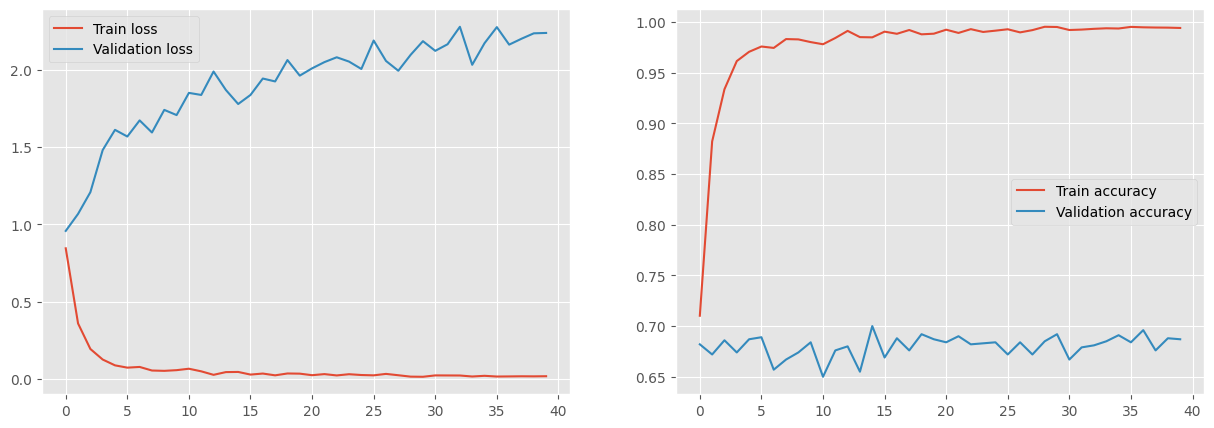

In [29]:
r = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(r.index, r['loss'], label='Train loss')
ax[0].plot(r.index, r['val_loss'], label='Validation loss')
ax[1].plot(r.index, r['accuracy'], label='Train accuracy')
ax[1].plot(r.index, r['val_accuracy'], label='Validation accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

## Saving checkpoints and Metrics

In [35]:
model.save('models/model/model_0.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
r.to_csv('data/reports/metrics/metrics_0.csv', index=False)

## Evaluation

In [40]:
y_pred = model.predict(val_data_features)
y_pred = np.argmax(y_pred, axis=1)

32/32 [==============================] - 0s 5ms/step


In [32]:
# Calculate precision, recall, and F1 score
accuracy = accuracy_score(val_data_labels_n, y_pred)
precision = precision_score(val_data_labels_n, y_pred, average='weighted')
recall = recall_score(val_data_labels_n, y_pred, average='weighted')
f1 = f1_score(val_data_labels_n, y_pred, average='weighted')

# Print the results
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.687
Precision: 0.6816070025458255
Recall: 0.687
F1 score: 0.6813609541348578


In [33]:
print(classification_report(val_data_labels_n, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.64      0.64       192
           1       0.54      0.50      0.52       175
           2       0.74      0.60      0.66        65
           3       0.39      0.45      0.42        77
           4       0.00      0.00      0.00        13
           5       0.82      0.87      0.85       458
           6       0.50      0.15      0.23        20

    accuracy                           0.69      1000
   macro avg       0.52      0.46      0.47      1000
weighted avg       0.68      0.69      0.68      1000



## Retrieving

In [34]:
test_data_features = np.load('data/processed/test/test_data_features.npy')

predictions = model.predict(test_data_features)

np.save('data/processed/test/output_0.npy', predictions)

32/32 [==============================] - 0s 5ms/step


# Output 1

## Loading Features and Labels

In [14]:
train_data_features = np.load('data/processed/train/train_data_features.npy')
train_data_labels = np.load('data/processed/train/train_labels.npy')

val_data_features = np.load('data/processed/val/val_data_features.npy')
val_data_labels = np.load('data/processed/val/val_labels.npy')

In [15]:
N = 1 # Choosing which label to work with

train_data_labels_n = train_data_labels[:, N]
print("Training distribution:", Counter(train_data_labels_n))

val_data_labels_n = val_data_labels[:, N]
print("Validation distribution:", Counter(val_data_labels_n))

Training distribution: Counter({2: 2615, 0: 1523, 1: 862})
Validation distribution: Counter({2: 531, 0: 301, 1: 168})


## Balancing training dataset

In [16]:
# Set the target number of samples for each class
target_samples = 1000

# Upsampling Minority classes using SMOTE
smote = SMOTE(sampling_strategy={
    1: 4000,
})

oversampled_features, oversampled_labels = smote.fit_resample(train_data_features, train_data_labels_n)

# Downsample the majority class using RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy={
    2: 2600
})

undersampled_features, undersampled_labels = undersampler.fit_resample(oversampled_features, oversampled_labels)

print("Class distribution after balancing:", Counter(undersampled_labels))
print("Shape of oversampled features:", undersampled_labels.shape)
print("Shape of oversampled labels:", undersampled_labels.shape)

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (4000) in class 1 will be larger than the number of samples in the majority class (class #2 -> 2615)
  warnings.warn(


Class distribution after balancing: Counter({1: 4000, 2: 2600, 0: 1523})
Shape of oversampled features: (8123,)
Shape of oversampled labels: (8123,)


## Training

In [17]:
input = Input(shape=(val_data_features.shape[1],))
x = Dense(512)(input)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = ReLU()(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = ReLU()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = ReLU()(x)

output = Dense(len(np.unique(train_data_labels_n)), activation='softmax', name=f'category_{1}_output')(x)

model = Model(inputs=[input], outputs=[output])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    undersampled_features, undersampled_labels,
    epochs=20,
    batch_size=32,
    validation_data = (val_data_features, val_data_labels_n)
)

Epoch 1/20
254/254 [==============================] - 19s 23ms/step - loss: 0.5242 - accuracy: 0.7934 - val_loss: 0.5448 - val_accuracy: 0.7730
Epoch 2/20
254/254 [==============================] - 4s 17ms/step - loss: 0.2018 - accuracy: 0.9281 - val_loss: 0.5838 - val_accuracy: 0.7950
Epoch 3/20
254/254 [==============================] - 4s 16ms/step - loss: 0.1166 - accuracy: 0.9593 - val_loss: 0.6360 - val_accuracy: 0.8040
Epoch 4/20
254/254 [==============================] - 5s 19ms/step - loss: 0.0757 - accuracy: 0.9724 - val_loss: 0.7088 - val_accuracy: 0.8100
Epoch 5/20
254/254 [==============================] - 4s 17ms/step - loss: 0.0576 - accuracy: 0.9812 - val_loss: 0.9751 - val_accuracy: 0.7660
Epoch 6/20
254/254 [==============================] - 4s 16ms/step - loss: 0.0550 - accuracy: 0.9804 - val_loss: 0.8356 - val_accuracy: 0.7900
Epoch 7/20
254/254 [==============================] - 5s 20ms/step - loss: 0.0592 - accuracy: 0.9801 - val_loss: 0.8380 - val_accuracy: 0.803

In [ ]:
r = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(r.index, r['loss'], label='Train loss')
ax[0].plot(r.index, r['val_loss'], label='Validation loss')
ax[1].plot(r.index, r['accuracy'], label='Train accuracy')
ax[1].plot(r.index, r['val_accuracy'], label='Validation accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

## Saving checkpoints and Metrics

In [ ]:
model.save('models/model/model_1.h5')

In [ ]:
r.to_csv('data/reports/metrics/metrics_1.csv', index=False)

## Evaluation

In [ ]:
y_pred = model.predict(val_data_features)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
# Calculate precision, recall, and F1 score
accuracy = accuracy_score(val_data_labels_n, y_pred)
precision = precision_score(val_data_labels_n, y_pred, average='weighted')
recall = recall_score(val_data_labels_n, y_pred, average='weighted')
f1 = f1_score(val_data_labels_n, y_pred, average='weighted')

# Print the results
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

In [ ]:
print(classification_report(val_data_labels_n, y_pred))

## Retrieving

In [ ]:
test_data_features = np.load('data/processed/test/test_data_features.npy')

predictions = model.predict(test_data_features)

np.save('data/processed/test/output_1.npy', predictions)

# Output 2

## Loading Features and Labels

In [ ]:
train_data_features = np.load('data/processed/train/train_data_features.npy')
train_data_labels = np.load('data/processed/train/train_labels.npy')

val_data_features = np.load('data/processed/val/val_data_features.npy')
val_data_labels = np.load('data/processed/val/val_labels.npy')

In [ ]:
N = 2 # Choosing which label to work with

train_data_labels_n = train_data_labels[:, N]
print("Training distribution:", Counter(train_data_labels_n))

val_data_labels_n = val_data_labels[:, N]
print("Validation distribution:", Counter(val_data_labels_n))

Training distribution: Counter({2: 3561, 1: 951, 0: 488})
Validation distribution: Counter({2: 727, 1: 173, 0: 100})


## Balancing training dataset

In [ ]:
# Set the target number of samples for each class
target_samples = 1000

# Upsampling Minority classes using SMOTE
smote = SMOTE(sampling_strategy={
    0: 5500,
    1: 3500,
})

oversampled_features, oversampled_labels = smote.fit_resample(train_data_features, train_data_labels_n)

# Downsample the majority class using RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy={
    2: 3000
})

undersampled_features, undersampled_labels = undersampler.fit_resample(oversampled_features, oversampled_labels)

print("Class distribution after balancing:", Counter(undersampled_labels))
print("Shape of oversampled features:", undersampled_labels.shape)
print("Shape of oversampled labels:", undersampled_labels.shape)

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (5500) in class 0 will be larger than the number of samples in the majority class (class #2 -> 3561)
  warnings.warn(


Class distribution after balancing: Counter({0: 5500, 1: 3500, 2: 3000})
Shape of oversampled features: (12000,)
Shape of oversampled labels: (12000,)


## Training

In [ ]:
input = Input(shape=(val_data_features.shape[1],))
x = Dense(512)(input)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = ReLU()(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = ReLU()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = ReLU()(x)

output = Dense(len(np.unique(train_data_labels_n)), activation='softmax', name=f'category_{1}_output')(x)

model = Model(inputs=[input], outputs=[output])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    undersampled_features, undersampled_labels,
    epochs=20,
    batch_size=32,
    validation_data = (val_data_features, val_data_labels_n)
)

Epoch 1/20
375/375 [==============================] - 12s 16ms/step - loss: 0.2434 - accuracy: 0.9133 - val_loss: 0.4652 - val_accuracy: 0.8630
Epoch 2/20
375/375 [==============================] - 6s 15ms/step - loss: 0.0842 - accuracy: 0.9712 - val_loss: 0.5264 - val_accuracy: 0.8630
Epoch 3/20
375/375 [==============================] - 5s 14ms/step - loss: 0.0548 - accuracy: 0.9822 - val_loss: 0.5581 - val_accuracy: 0.8620
Epoch 4/20
375/375 [==============================] - 6s 15ms/step - loss: 0.0374 - accuracy: 0.9880 - val_loss: 0.6947 - val_accuracy: 0.8540
Epoch 5/20
375/375 [==============================] - 5s 14ms/step - loss: 0.0307 - accuracy: 0.9882 - val_loss: 0.6005 - val_accuracy: 0.8680
Epoch 6/20
375/375 [==============================] - 6s 15ms/step - loss: 0.0230 - accuracy: 0.9920 - val_loss: 0.6306 - val_accuracy: 0.8750
Epoch 7/20
375/375 [==============================] - 6s 15ms/step - loss: 0.0246 - accuracy: 0.9931 - val_loss: 0.6203 - val_accuracy: 0.881

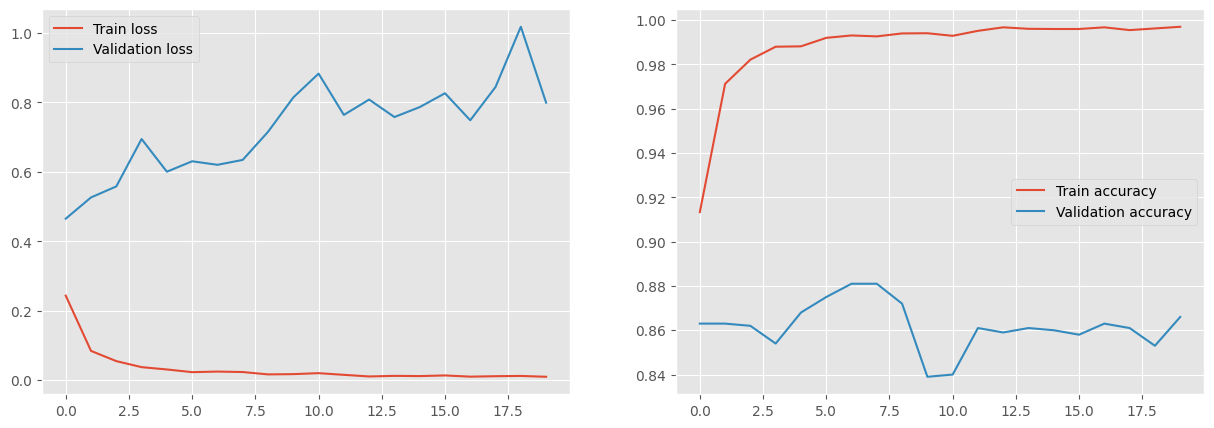

In [ ]:
r = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(r.index, r['loss'], label='Train loss')
ax[0].plot(r.index, r['val_loss'], label='Validation loss')
ax[1].plot(r.index, r['accuracy'], label='Train accuracy')
ax[1].plot(r.index, r['val_accuracy'], label='Validation accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

## Saving checkpoints and Metrics

In [ ]:
model.save('models/model/model_2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
r.to_csv('reports/metrics/metrics_2.csv', index=False)

## Evaluation

In [ ]:
y_pred = model.predict(val_data_features)
y_pred = np.argmax(y_pred, axis=1)

32/32 [==============================] - 0s 5ms/step


In [ ]:
# Calculate precision, recall, and F1 score
accuracy = accuracy_score(val_data_labels_n, y_pred)
precision = precision_score(val_data_labels_n, y_pred, average='weighted')
recall = recall_score(val_data_labels_n, y_pred, average='weighted')
f1 = f1_score(val_data_labels_n, y_pred, average='weighted')

# Print the results
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.864
Precision: 0.8753670662184696
Recall: 0.864
F1 score: 0.8674978816317676


In [ ]:
print(classification_report(val_data_labels_n, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       100
           1       0.65      0.82      0.73       173
           2       0.94      0.89      0.92       727

    accuracy                           0.86      1000
   macro avg       0.80      0.81      0.80      1000
weighted avg       0.88      0.86      0.87      1000



## Retrieving

In [ ]:
test_data_features = np.load('data/processed/test/test_data_features.npy')

predictions = model.predict(test_data_features)

np.save('data/processed/test/output_2.npy', predictions)

32/32 [==============================] - 0s 5ms/step


# Output 3

## Loading Features and Labels

In [ ]:
train_data_features = np.load('data/processed/train/train_data_features.npy')
train_data_labels = np.load('data/processed/train/train_labels.npy')

val_data_features = np.load('data/processed/val/val_data_features.npy')
val_data_labels = np.load('data/processed/val/val_labels.npy')

In [ ]:
N = 3 # Choosing which label to work with

train_data_labels_n = train_data_labels[:, N]
print("Training distribution:", Counter(train_data_labels_n))

val_data_labels_n = val_data_labels[:, N]
print("Validation distribution:", Counter(val_data_labels_n))

Training distribution: Counter({0: 2086, 3: 2069, 1: 826, 2: 19})
Validation distribution: Counter({3: 438, 0: 387, 1: 173, 2: 2})


## Balancing training dataset

In [ ]:
# Upsampling Minority classes using SMOTE
smote = SMOTE(sampling_strategy={
    2: 1000,
    1: 3000,
})

oversampled_features, oversampled_labels = smote.fit_resample(train_data_features, train_data_labels_n)

# Downsample the majority class using RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy={
    0: 2000,
    3: 2000
})

undersampled_features, undersampled_labels = undersampler.fit_resample(oversampled_features, oversampled_labels)

print("Class distribution after balancing:", Counter(undersampled_labels))
print("Shape of oversampled features:", undersampled_labels.shape)
print("Shape of oversampled labels:", undersampled_labels.shape)

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (3000) in class 1 will be larger than the number of samples in the majority class (class #0 -> 2086)
  warnings.warn(


Class distribution after balancing: Counter({1: 3000, 0: 2000, 3: 2000, 2: 1000})
Shape of oversampled features: (8000,)
Shape of oversampled labels: (8000,)


## Training

In [ ]:
input = Input(shape=(val_data_features.shape[1],))
x = Dense(512)(input)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = ReLU()(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = ReLU()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = ReLU()(x)

output = Dense(len(np.unique(train_data_labels_n)), activation='softmax', name=f'category_{1}_output')(x)

model = Model(inputs=[input], outputs=[output])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    undersampled_features, undersampled_labels,
    epochs=20,
    batch_size=32,
    validation_data = (val_data_features, val_data_labels_n)
)

Epoch 1/20
250/250 [==============================] - 11s 18ms/step - loss: 0.7212 - accuracy: 0.6986 - val_loss: 0.9449 - val_accuracy: 0.6180
Epoch 2/20
250/250 [==============================] - 4s 15ms/step - loss: 0.3783 - accuracy: 0.8491 - val_loss: 0.9005 - val_accuracy: 0.6440
Epoch 3/20
250/250 [==============================] - 4s 16ms/step - loss: 0.2348 - accuracy: 0.9116 - val_loss: 1.0781 - val_accuracy: 0.6330
Epoch 4/20
250/250 [==============================] - 4s 16ms/step - loss: 0.1628 - accuracy: 0.9401 - val_loss: 1.2307 - val_accuracy: 0.6350
Epoch 5/20
250/250 [==============================] - 4s 14ms/step - loss: 0.1110 - accuracy: 0.9585 - val_loss: 1.2823 - val_accuracy: 0.6530
Epoch 6/20
250/250 [==============================] - 4s 14ms/step - loss: 0.0963 - accuracy: 0.9666 - val_loss: 1.5132 - val_accuracy: 0.6340
Epoch 7/20
250/250 [==============================] - 4s 16ms/step - loss: 0.0884 - accuracy: 0.9670 - val_loss: 1.4118 - val_accuracy: 0.662

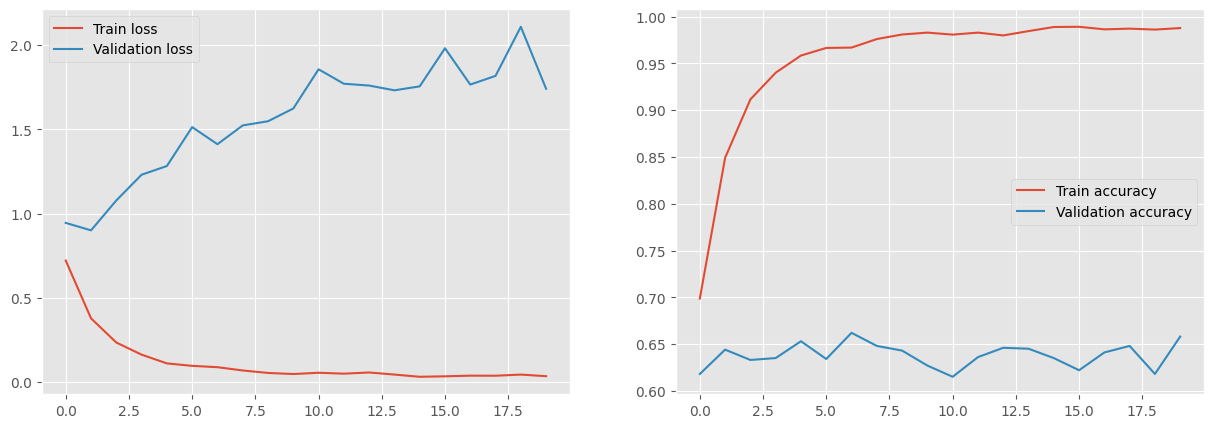

In [ ]:
r = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(r.index, r['loss'], label='Train loss')
ax[0].plot(r.index, r['val_loss'], label='Validation loss')
ax[1].plot(r.index, r['accuracy'], label='Train accuracy')
ax[1].plot(r.index, r['val_accuracy'], label='Validation accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

## Saving checkpoints and Metrics

In [ ]:
model.save('models/model/model_3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
r.to_csv('reports/metrics/metrics_3.csv', index=False)

## Evaluation

In [ ]:
y_pred = model.predict(val_data_features)
y_pred = np.argmax(y_pred, axis=1)

32/32 [==============================] - 0s 6ms/step


In [ ]:
# Calculate precision, recall, and F1 score
accuracy = accuracy_score(val_data_labels_n, y_pred)
precision = precision_score(val_data_labels_n, y_pred, average='weighted')
recall = recall_score(val_data_labels_n, y_pred, average='weighted')
f1 = f1_score(val_data_labels_n, y_pred, average='weighted')

# Print the results
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.661
Precision: 0.656064421097781
Recall: 0.661
F1 score: 0.6492725410164065


In [ ]:
print(classification_report(val_data_labels_n, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.74      0.68       387
           1       0.58      0.31      0.40       173
           2       0.00      0.00      0.00         2
           3       0.72      0.73      0.73       438

    accuracy                           0.66      1000
   macro avg       0.48      0.45      0.45      1000
weighted avg       0.66      0.66      0.65      1000



## Retrieving

In [ ]:
test_data_features = np.load('data/processed/test/test_data_features.npy')

predictions = model.predict(test_data_features)

np.save('data/processed/test/output_3.npy', predictions)

32/32 [==============================] - 0s 7ms/step


# Output 4

## Loading Features and Labels

In [ ]:
train_data_features = np.load('data/processed/train/train_data_features.npy')
train_data_labels = np.load('data/processed/train/train_labels.npy')

val_data_features = np.load('data/processed/val/val_data_features.npy')
val_data_labels = np.load('data/processed/val/val_labels.npy')

In [ ]:
N = 4 # Choosing which label to work with

train_data_labels_n = train_data_labels[:, N]
print("Training distribution:", Counter(train_data_labels_n))

val_data_labels_n = val_data_labels[:, N]
print("Validation distribution:", Counter(val_data_labels_n))

Training distribution: Counter({2: 3399, 1: 702, 5: 436, 0: 310, 3: 105, 4: 48})
Validation distribution: Counter({2: 680, 1: 146, 5: 92, 0: 56, 3: 16, 4: 10})


## Balancing training dataset

In [ ]:
# Upsampling Minority classes using SMOTE
smote = SMOTE(sampling_strategy={
    0: 2000,
    1: 3000,
    5: 2000,
    3: 800,
    4: 500
})

oversampled_features, oversampled_labels = smote.fit_resample(train_data_features, train_data_labels_n)

# Downsample the majority class using RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy={
    2: 3300
})

undersampled_features, undersampled_labels = undersampler.fit_resample(oversampled_features, oversampled_labels)

print("Class distribution after balancing:", Counter(undersampled_labels))
print("Shape of oversampled features:", undersampled_labels.shape)
print("Shape of oversampled labels:", undersampled_labels.shape)

Class distribution after balancing: Counter({2: 3300, 1: 3000, 0: 2000, 5: 2000, 3: 800, 4: 500})
Shape of oversampled features: (11600,)
Shape of oversampled labels: (11600,)


## Training

In [ ]:
input = Input(shape=(val_data_features.shape[1],))
x = Dense(512)(input)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = ReLU()(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = ReLU()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = ReLU()(x)

output = Dense(len(np.unique(train_data_labels_n)), activation='softmax', name=f'category_{1}_output')(x)

model = Model(inputs=[input], outputs=[output])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    undersampled_features, undersampled_labels,
    epochs=20,
    batch_size=32,
    validation_data = (val_data_features, val_data_labels_n)
)

Epoch 1/20
363/363 [==============================] - 14s 19ms/step - loss: 0.7169 - accuracy: 0.7300 - val_loss: 1.0196 - val_accuracy: 0.6220
Epoch 2/20
363/363 [==============================] - 6s 15ms/step - loss: 0.2452 - accuracy: 0.9109 - val_loss: 1.1099 - val_accuracy: 0.7070
Epoch 3/20
363/363 [==============================] - 6s 16ms/step - loss: 0.1290 - accuracy: 0.9551 - val_loss: 1.2830 - val_accuracy: 0.6790
Epoch 4/20
363/363 [==============================] - 6s 15ms/step - loss: 0.0943 - accuracy: 0.9672 - val_loss: 1.3910 - val_accuracy: 0.6530
Epoch 5/20
363/363 [==============================] - 6s 16ms/step - loss: 0.0707 - accuracy: 0.9747 - val_loss: 1.6160 - val_accuracy: 0.6880
Epoch 6/20
363/363 [==============================] - 5s 15ms/step - loss: 0.0728 - accuracy: 0.9744 - val_loss: 1.4834 - val_accuracy: 0.6620
Epoch 7/20
363/363 [==============================] - 6s 16ms/step - loss: 0.0459 - accuracy: 0.9847 - val_loss: 1.7389 - val_accuracy: 0.692

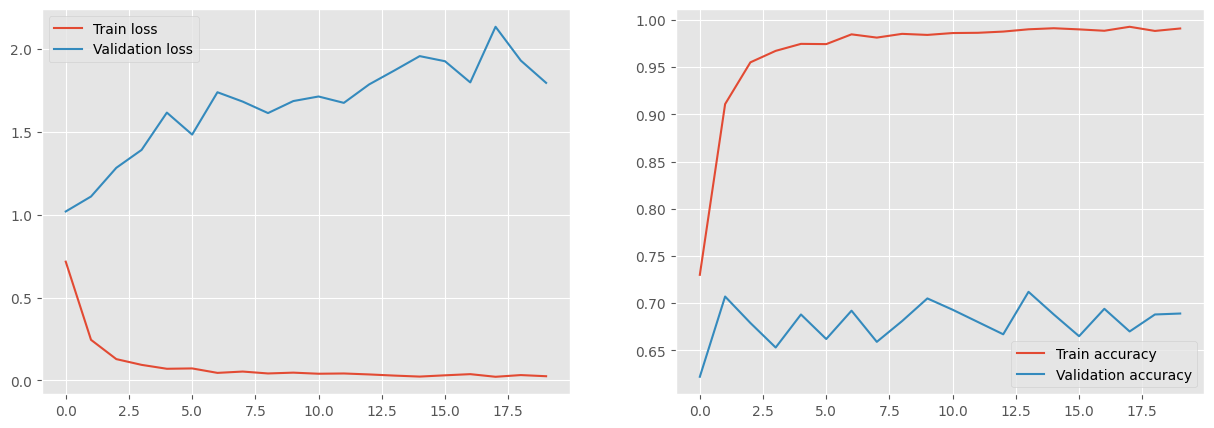

In [ ]:
r = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(r.index, r['loss'], label='Train loss')
ax[0].plot(r.index, r['val_loss'], label='Validation loss')
ax[1].plot(r.index, r['accuracy'], label='Train accuracy')
ax[1].plot(r.index, r['val_accuracy'], label='Validation accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

## Saving checkpoints and Metrics

In [ ]:
model.save('models/model/model_4.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
r.to_csv('reports/metrics/metrics_4.csv', index=False)

## Evaluation

In [ ]:
y_pred = model.predict(val_data_features)
y_pred = np.argmax(y_pred, axis=1)

32/32 [==============================] - 0s 5ms/step


In [ ]:
# Calculate precision, recall, and F1 score
accuracy = accuracy_score(val_data_labels_n, y_pred)
precision = precision_score(val_data_labels_n, y_pred, average='weighted')
recall = recall_score(val_data_labels_n, y_pred, average='weighted')
f1 = f1_score(val_data_labels_n, y_pred, average='weighted')

# Print the results
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.694
Precision: 0.6757415830173272
Recall: 0.694
F1 score: 0.6778084501542047


In [ ]:
print(classification_report(val_data_labels_n, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.45      0.51        56
           1       0.46      0.39      0.42       146
           2       0.77      0.86      0.81       680
           3       0.06      0.06      0.06        16
           4       0.31      0.50      0.38        10
           5       0.52      0.25      0.34        92

    accuracy                           0.69      1000
   macro avg       0.45      0.42      0.42      1000
weighted avg       0.68      0.69      0.68      1000



## Retrieving

In [ ]:
test_data_features = np.load('data/processed/test/test_data_features.npy')

predictions = model.predict(test_data_features)

np.save('data/processed/test/output_4.npy', predictions)

32/32 [==============================] - 0s 5ms/step


# Output 5

## Loading Features and Labels

In [ ]:
train_data_features = np.load('data/processed/train/train_data_features.npy')
train_data_labels = np.load('data/processed/train/train_labels.npy')

val_data_features = np.load('data/processed/val/val_data_features.npy')
val_data_labels = np.load('data/processed/val/val_labels.npy')

In [ ]:
N = 5 # Choosing which label to work with

train_data_labels_n = train_data_labels[:, N]
print("Training distribution:", Counter(train_data_labels_n))

val_data_labels_n = val_data_labels[:, N]
print("Validation distribution:", Counter(val_data_labels_n))

Training distribution: Counter({2: 3972, 0: 749, 1: 279})
Validation distribution: Counter({2: 801, 0: 129, 1: 70})


## Balancing training dataset

In [ ]:
# Set the target number of samples for each class
target_samples = 1000

# Upsampling Minority classes using SMOTE
smote = SMOTE(sampling_strategy={
    0: 3000,
    1: 5000,
})

oversampled_features, oversampled_labels = smote.fit_resample(train_data_features, train_data_labels_n)

# Downsample the majority class using RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy={
    2: 3000
})

undersampled_features, undersampled_labels = undersampler.fit_resample(oversampled_features, oversampled_labels)

print("Class distribution after balancing:", Counter(undersampled_labels))
print("Shape of oversampled features:", undersampled_labels.shape)
print("Shape of oversampled labels:", undersampled_labels.shape)

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (5000) in class 1 will be larger than the number of samples in the majority class (class #2 -> 3972)
  warnings.warn(


Class distribution after balancing: Counter({1: 5000, 0: 3000, 2: 3000})
Shape of oversampled features: (11000,)
Shape of oversampled labels: (11000,)


## Training

In [ ]:
input = Input(shape=(val_data_features.shape[1],))
x = Dense(512)(input)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = ReLU()(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = ReLU()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = ReLU()(x)

output = Dense(len(np.unique(train_data_labels_n)), activation='softmax', name=f'category_{1}_output')(x)

model = Model(inputs=[input], outputs=[output])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    undersampled_features, undersampled_labels,
    epochs=20,
    batch_size=32,
    validation_data = (val_data_features, val_data_labels_n)
)

Epoch 1/20
344/344 [==============================] - 16s 23ms/step - loss: 0.4160 - accuracy: 0.8338 - val_loss: 0.7201 - val_accuracy: 0.7590
Epoch 2/20
344/344 [==============================] - 9s 25ms/step - loss: 0.1528 - accuracy: 0.9417 - val_loss: 0.7175 - val_accuracy: 0.7980
Epoch 3/20
344/344 [==============================] - 9s 25ms/step - loss: 0.0827 - accuracy: 0.9715 - val_loss: 0.9708 - val_accuracy: 0.7840
Epoch 4/20
344/344 [==============================] - 7s 21ms/step - loss: 0.0551 - accuracy: 0.9823 - val_loss: 0.9194 - val_accuracy: 0.8090
Epoch 5/20
344/344 [==============================] - 7s 20ms/step - loss: 0.0462 - accuracy: 0.9848 - val_loss: 0.9594 - val_accuracy: 0.8180
Epoch 6/20
344/344 [==============================] - 5s 15ms/step - loss: 0.0419 - accuracy: 0.9849 - val_loss: 1.0441 - val_accuracy: 0.7930
Epoch 7/20
344/344 [==============================] - 6s 17ms/step - loss: 0.0419 - accuracy: 0.9860 - val_loss: 0.9994 - val_accuracy: 0.790

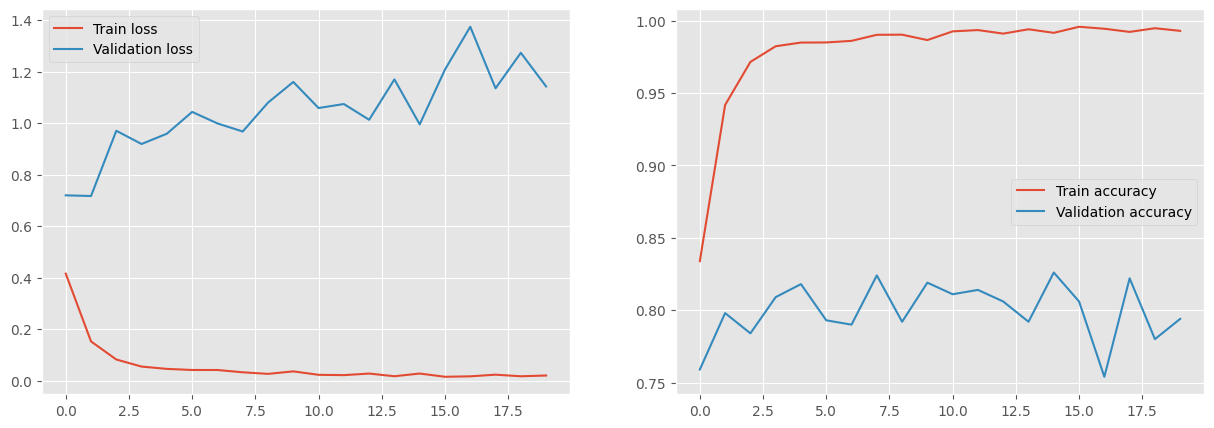

In [ ]:
r = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(r.index, r['loss'], label='Train loss')
ax[0].plot(r.index, r['val_loss'], label='Validation loss')
ax[1].plot(r.index, r['accuracy'], label='Train accuracy')
ax[1].plot(r.index, r['val_accuracy'], label='Validation accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

## Saving checkpoints and Metrics

In [ ]:
model.save('models/model/model_5.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
r.to_csv('reports/metrics/metrics_5.csv', index=False)

## Evaluation

In [ ]:
y_pred = model.predict(val_data_features)
y_pred = np.argmax(y_pred, axis=1)

32/32 [==============================] - 0s 6ms/step


In [ ]:
# Calculate precision, recall, and F1 score
accuracy = accuracy_score(val_data_labels_n, y_pred)
precision = precision_score(val_data_labels_n, y_pred, average='weighted')
recall = recall_score(val_data_labels_n, y_pred, average='weighted')
f1 = f1_score(val_data_labels_n, y_pred, average='weighted')

# Print the results
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.814
Precision: 0.7692337869419154
Recall: 0.814
F1 score: 0.7840914700272988


In [ ]:
print(classification_report(val_data_labels_n, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.43      0.50       129
           1       0.20      0.04      0.07        70
           2       0.85      0.94      0.89       801

    accuracy                           0.81      1000
   macro avg       0.55      0.47      0.49      1000
weighted avg       0.77      0.81      0.78      1000



## Retrieving

In [ ]:
test_data_features = np.load('data/processed/test/test_data_features.npy')

predictions = model.predict(test_data_features)

np.save('data/processed/test/output_5.npy', predictions)

32/32 [==============================] - 0s 5ms/step


# Evaluation

In [ ]:
loss = []
val_loss = []
accuracy = []
val_accuracy = []

for i in range(6):
  filename = f'reports/metrics/metrics_{i}.csv'
  metrics = pd.read_csv(filename)

  loss.append(metrics.loss.values)
  val_loss.append(metrics.val_loss.values)
  accuracy.append(metrics.accuracy.values)
  val_accuracy.append(metrics.val_accuracy.values)

loss = np.array(loss).sum(axis=0)
val_loss = np.array(val_loss).sum(axis=0)
accuracy = np.array(accuracy).mean(axis=0)
val_accuracy = np.array(val_accuracy).mean(axis=0)

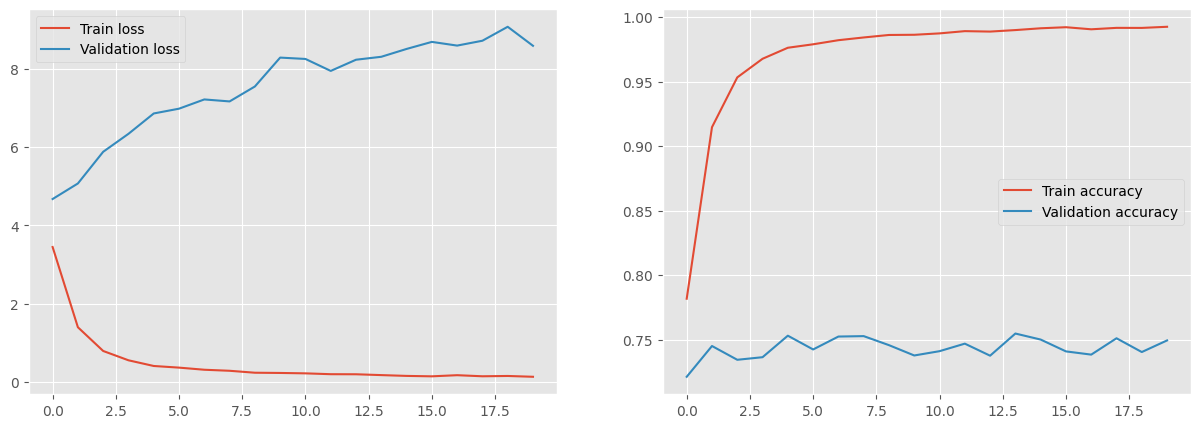

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss, label='Train loss')
ax[0].plot(val_loss, label='Validation loss')
ax[1].plot(accuracy, label='Train accuracy')
ax[1].plot(val_accuracy, label='Validation accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
print('Total Train loss:', loss.sum())
print('Total Validation loss', val_loss.sum())

Total Train loss: 9.771645749919113
Total Validation loss 150.81500497460365


In [ ]:
print('Total Train Accuacy:', accuracy.mean())
print('Total Validation Accuracy:', val_accuracy.mean())

Total Train Accuacy: 0.9708231742183366
Total Validation Accuracy: 0.7436833297212919


# Inference

In [ ]:
# Initialize an empty array to store combined predictions
formatted_predictions = []

# Load individual npy files and combine them
for i in range(6):  # assuming 6 files output_0.npy to output_5.npy
    filename = f"data/processed/test/output_{i}.npy"
    prediction = np.load(filename)
    prediction = np.argmax(prediction, axis=1)
    formatted_predictions.append(prediction)

formatted_predictions = np.array(formatted_predictions).T

In [ ]:
# Store the formatted predictions in a text file
output_file = 'data/processed/test/predictions.txt'
with open(output_file, 'w') as f:
    for prediction in formatted_predictions:
        f.write(' '.join(map(str, prediction)) + '\n')

print(f"Formatted predictions saved to {output_file}")

Formatted predictions saved to /content/drive/MyDrive/predictions.txt
